In [14]:
import os
import sys
home_dir = "../../"
module_path = os.path.abspath(os.path.join(home_dir))
if module_path not in sys.path:
    sys.path.append(module_path)

import random
import numpy as np
import pandas as pd
from models.aa_common.performance_metrics import *

In [18]:
task = "pmd_analysis"
negative_cls = "No-effect"
positive_cls = "Effect"
n_samples = 10000
# ("dbnsfp", "sift"), ("dbnsfp", "polyphen2_HVAR"), ("dbnsfp", "cadd"), ("dbnsfp", "mvp"), ("dbnsfp", "metarnn"), ("dbnsfp", "revel"),
model_root_and_name_tuple_list = [("tape_rao", "unirep"), ("tape_rao", "protbert"), ("sequnet_dunham", "sequnet"), 
                                  ("esm_rives", "esm1b_t33_650M_UR50S"), ("esm_rives", "esm1v_t33_650M_UR90S"), ("esm_rives", "esm2_t33_650M_UR50D"),
                                  ("bioembeddings_dallago", "plus_rnn"), 
                                  ("bioembeddings_dallago", "prottrans_bert_bfd"), ("bioembeddings_dallago", "prottrans_albert_bfd"),
                                  ("bioembeddings_dallago", "prottrans_xlnet_uniref100"), 
                                  ("bioembeddings_dallago", "prottrans_t5_bfd"), ("bioembeddings_dallago", "prottrans_t5_uniref50"), ("bioembeddings_dallago", "prottrans_t5_xl_u50"),
                                  ("", "random_classifier")]

# by default, we consider larger means positive class (here Effect), but the following models have specific opposite meaning
models_smaller_means_damaging = ["sequnet", "sift"]

metrics = ["KS-statistic", "KS-pvalue", "AUC-ROC", "AUC-PR", "F1-max", "Th-max", "Precision", "Recall", "Accuracy", "Balanced-accuracy", "MCC", "Missing values (%)"]

In [16]:
result_df = pd.read_csv(home_dir+f"models/aa_common/merged_predictions/{task}.csv", sep="\t")
print(result_df.shape)
print(result_df.columns)

result_df.loc[result_df["functional_effect"]=="Effect","class"] = "Effect"
result_df.loc[result_df["functional_effect"]=="Knock-out","class"] = "Effect"
result_df.loc[result_df["functional_effect"]=="No effect","class"] = "No-effect"

result_df["class"].value_counts()

(51047, 28)
Index(['mut_id', 'pmd_id', 'protein', 'mut_PMD', 'mut_real', 'function',
       'taxid', 'function_e', 'function_e2', 'functional_effect', 'seq',
       'protein_id', 'wt', 'mut', 'prot_pos', 'unirep_pred', 'protbert_pred',
       'sequnet_pred', 'esm1b_t33_650M_UR50S_pred',
       'esm1v_t33_650M_UR90S_pred', 'esm2_t33_650M_UR50D_pred',
       'plus_rnn_pred', 'prottrans_bert_bfd_pred', 'prottrans_albert_bfd_pred',
       'prottrans_xlnet_uniref100_pred', 'prottrans_t5_bfd_pred',
       'prottrans_t5_uniref50_pred', 'prottrans_t5_xl_u50_pred'],
      dtype='object')


Effect       37750
No-effect    13297
Name: class, dtype: int64

### Computing all methods performance metrics

In [17]:
def get_non_nan_df(df, col_name):
    non_nan_df = df[~pd.isna(df[col_name])]  # taking df for only non-NAN values
    
    n_missing = df[pd.isna(df[col_name])].shape[0] 
    total = df.shape[0]
    missing_values_percentage = (n_missing / total) * 100
    print(f"\tMissing values: 100*{n_missing}/{total}={missing_values_percentage}")
    
    return non_nan_df, missing_values_percentage

def calibrate_prediction_scores_direction(df, model_name):
    if model_name in models_smaller_means_damaging:
        df['pred'] = df['pred'].multiply(-1)
    
    auc_roc_score, larger_means_positive_class = get_auc_roc_score(df)
    if not larger_means_positive_class:
        df['pred'] = df['pred'].multiply(-1)
    
    return df, auc_roc_score

def sample_positive_and_negative_data_points(df):
    df = df.copy(deep=True)
    positive_cls_result_df = df[df["class"]==positive_cls].sample(n=n_samples)
    negative_cls_result_df = df[df["class"]==negative_cls].sample(n=n_samples)
    
    positive_cls_result_df["class_numeric"] = 1
    negative_cls_result_df["class_numeric"] = 0
    print(f"\t{positive_cls}(+ve): {positive_cls_result_df.shape}, {negative_cls}(-ve): {negative_cls_result_df.shape}")
    
    result_df = pd.concat([positive_cls_result_df, negative_cls_result_df])
    return result_df

In [19]:
performance_scores_dict = {}
for i, (model_root, model_name) in enumerate(model_root_and_name_tuple_list):
    print(model_name)
    model_pred_col = model_name + "_pred"
    performance_scores = []

    for i_run in range(10): #10 runs
        sampled_result_df = sample_positive_and_negative_data_points(result_df)
        
        if model_name=="random_classifier": sampled_result_df[model_pred_col] = [random.uniform(0, 1) for i in range(sampled_result_df.shape[0])]
        
        sampled_result_df["pred"]=(sampled_result_df[model_pred_col]-sampled_result_df[model_pred_col].min())/(sampled_result_df[model_pred_col].max()-sampled_result_df[model_pred_col].min()) # scaling prediction scores between [0, 1]
        
        non_nan_result_df, missing_values_percentage = get_non_nan_df(sampled_result_df, model_pred_col)
        
        non_nan_result_df, auc_roc_score =  calibrate_prediction_scores_direction(non_nan_result_df, model_name)
        
        ks_statistic, ks_pvalue = get_KS_test_score(non_nan_result_df)
        auc_pr_score, precisions, recalls, thresholds = get_auc_pr_score(non_nan_result_df)
        f1_max, th_max, precisions, recalls, thresholds = get_f1max_and_th(precisions, recalls, thresholds)
        precision = get_precision_score(non_nan_result_df, th_max)
        recall = get_recall_score(non_nan_result_df, th_max)
        accuracy = get_accuracy_score(non_nan_result_df, th_max)
        balanced_accuracy = get_balanced_accuracy_score(non_nan_result_df, th_max)
        mcc = get_matthews_corrcoef(non_nan_result_df, th_max)
        
        performance_scores.append([ks_statistic, ks_pvalue, auc_roc_score, auc_pr_score, f1_max, th_max, precision, recall, accuracy, balanced_accuracy, mcc, missing_values_percentage])
        print()
        
    performance_scores_dict[model_name] = performance_scores

unirep
	Effect(+ve): (10000, 30), No-effect(-ve): (10000, 30)
	Missing values: 100*0/20000=0.0
	AUC-ROC: 0.517
	KS-test score. statistic: 0.043, p-value: 0.000
	AUC-PR: 0.510
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Effect(+ve): (10000, 30), No-effect(-ve): (10000, 30)
	Missing values: 100*0/20000=0.0
	AUC-ROC: 0.519
	KS-test score. statistic: 0.048, p-value: 0.000
	AUC-PR: 0.512
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Effect(+ve): (10000, 30), No-effect(-ve): (10000, 30)
	Missing values: 100*0/20000=0.0
	AUC-ROC: 0.512
	KS-test score. statistic: 0.03

/tmp/ipykernel_3506036/3419917435.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred'] = df['pred'].multiply(-1)
/tmp/ipykernel_3506036/3419917435.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred'] = df['pred'].multiply(-1)


	KS-test score. statistic: 0.157, p-value: 0.000
	AUC-PR: 0.589
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Effect(+ve): (10000, 30), No-effect(-ve): (10000, 30)
	Missing values: 100*22/20000=0.11
	AUC-ROC: 0.401


/tmp/ipykernel_3506036/3419917435.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred'] = df['pred'].multiply(-1)
/tmp/ipykernel_3506036/3419917435.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred'] = df['pred'].multiply(-1)


	KS-test score. statistic: 0.156, p-value: 0.000
	AUC-PR: 0.588
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.502 at threshold: 0.000
	Recall score: 0.995 at threshold: 0.000
	Accuracy score: 0.504 at threshold: 0.000
	Balanced accuracy score: 0.503 at threshold: 0.000
	MCC score: 0.037 at threshold: 0.000

	Effect(+ve): (10000, 30), No-effect(-ve): (10000, 30)
	Missing values: 100*19/20000=0.095
	AUC-ROC: 0.402


/tmp/ipykernel_3506036/3419917435.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred'] = df['pred'].multiply(-1)
/tmp/ipykernel_3506036/3419917435.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred'] = df['pred'].multiply(-1)


	KS-test score. statistic: 0.152, p-value: 0.000
	AUC-PR: 0.583
	Best F1-Score: 0.668 at threshold: 0.001
	Precision score: 0.508 at threshold: 0.001
	Recall score: 0.973 at threshold: 0.001
	Accuracy score: 0.516 at threshold: 0.001
	Balanced accuracy score: 0.516 at threshold: 0.001
	MCC score: 0.079 at threshold: 0.001

	Effect(+ve): (10000, 30), No-effect(-ve): (10000, 30)
	Missing values: 100*22/20000=0.11
	AUC-ROC: 0.406


/tmp/ipykernel_3506036/3419917435.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred'] = df['pred'].multiply(-1)
/tmp/ipykernel_3506036/3419917435.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred'] = df['pred'].multiply(-1)


	KS-test score. statistic: 0.146, p-value: 0.000
	AUC-PR: 0.580
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.501 at threshold: 0.000
	Recall score: 0.998 at threshold: 0.000
	Accuracy score: 0.501 at threshold: 0.000
	Balanced accuracy score: 0.501 at threshold: 0.000
	MCC score: 0.026 at threshold: 0.000

	Effect(+ve): (10000, 30), No-effect(-ve): (10000, 30)
	Missing values: 100*16/20000=0.08
	AUC-ROC: 0.406


/tmp/ipykernel_3506036/3419917435.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred'] = df['pred'].multiply(-1)
/tmp/ipykernel_3506036/3419917435.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred'] = df['pred'].multiply(-1)


	KS-test score. statistic: 0.145, p-value: 0.000
	AUC-PR: 0.582
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.503 at threshold: 0.000
	Recall score: 0.990 at threshold: 0.000
	Accuracy score: 0.506 at threshold: 0.000
	Balanced accuracy score: 0.505 at threshold: 0.000
	MCC score: 0.044 at threshold: 0.000

	Effect(+ve): (10000, 30), No-effect(-ve): (10000, 30)
	Missing values: 100*15/20000=0.075
	AUC-ROC: 0.406


/tmp/ipykernel_3506036/3419917435.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred'] = df['pred'].multiply(-1)
/tmp/ipykernel_3506036/3419917435.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred'] = df['pred'].multiply(-1)


	KS-test score. statistic: 0.148, p-value: 0.000
	AUC-PR: 0.579
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Effect(+ve): (10000, 30), No-effect(-ve): (10000, 30)
	Missing values: 100*25/20000=0.125
	AUC-ROC: 0.401


/tmp/ipykernel_3506036/3419917435.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred'] = df['pred'].multiply(-1)
/tmp/ipykernel_3506036/3419917435.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred'] = df['pred'].multiply(-1)


	KS-test score. statistic: 0.160, p-value: 0.000
	AUC-PR: 0.586
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.503 at threshold: 0.000
	Recall score: 0.991 at threshold: 0.000
	Accuracy score: 0.505 at threshold: 0.000
	Balanced accuracy score: 0.505 at threshold: 0.000
	MCC score: 0.044 at threshold: 0.000

	Effect(+ve): (10000, 30), No-effect(-ve): (10000, 30)
	Missing values: 100*22/20000=0.11
	AUC-ROC: 0.406


/tmp/ipykernel_3506036/3419917435.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred'] = df['pred'].multiply(-1)
/tmp/ipykernel_3506036/3419917435.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred'] = df['pred'].multiply(-1)


	KS-test score. statistic: 0.148, p-value: 0.000
	AUC-PR: 0.580
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Effect(+ve): (10000, 30), No-effect(-ve): (10000, 30)
	Missing values: 100*15/20000=0.075
	AUC-ROC: 0.399


/tmp/ipykernel_3506036/3419917435.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred'] = df['pred'].multiply(-1)
/tmp/ipykernel_3506036/3419917435.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred'] = df['pred'].multiply(-1)


	KS-test score. statistic: 0.158, p-value: 0.000
	AUC-PR: 0.587
	Best F1-Score: 0.667 at threshold: 0.001
	Precision score: 0.509 at threshold: 0.001
	Recall score: 0.967 at threshold: 0.001
	Accuracy score: 0.518 at threshold: 0.001
	Balanced accuracy score: 0.518 at threshold: 0.001
	MCC score: 0.081 at threshold: 0.001

	Effect(+ve): (10000, 30), No-effect(-ve): (10000, 30)
	Missing values: 100*24/20000=0.12
	AUC-ROC: 0.403


/tmp/ipykernel_3506036/3419917435.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred'] = df['pred'].multiply(-1)
/tmp/ipykernel_3506036/3419917435.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred'] = df['pred'].multiply(-1)


	KS-test score. statistic: 0.149, p-value: 0.000
	AUC-PR: 0.583
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall score: 0.999 at threshold: 0.000
	Accuracy score: 0.501 at threshold: 0.000
	Balanced accuracy score: 0.501 at threshold: 0.000
	MCC score: 0.016 at threshold: 0.000

esm1b_t33_650M_UR50S
	Effect(+ve): (10000, 30), No-effect(-ve): (10000, 30)
	Missing values: 100*0/20000=0.0
	AUC-ROC: 0.328
	KS-test score. statistic: 0.288, p-value: 0.000
	AUC-PR: 0.663
	Best F1-Score: 0.667 at threshold: -0.846
	Precision score: 0.500 at threshold: -0.846
	Recall score: 1.000 at threshold: -0.846
	Accuracy score: 0.500 at threshold: -0.846
	Balanced accuracy score: 0.501 at threshold: -0.846
	MCC score: 0.016 at threshold: -0.846

	Effect(+ve): (10000, 30), No-effect(-ve): (10000, 30)
	Missing values: 100*0/20000=0.0
	AUC-ROC: 0.335
	KS-test score. statistic: 0.271, p-value: 0.000
	AUC-PR: 0.655
	Best F1-Score: 0.667 at threshold: -1.000
	Precisi

In [20]:
output_file = home_dir+f"models/aa_common/performance_analysis/{task}.csv"

out = open(output_file, 'w')
out.write("Models\\Metrics")
for metric in metrics:
    out.write(f"\t{metric}")
out.write("\n")

for (model_name, performance_scores) in performance_scores_dict.items():
    out.write(f"{model_name}")
    for scores in performance_scores:
        for score in scores:
            out.write(f"\t{score:.3f}")
        out.write("\n")
    out.write("\n")
    
for (model_name, performance_scores) in performance_scores_dict.items():
    out.write(f"{model_name}")    
    avg_scores = np.mean(performance_scores, axis=0)
    std_scores = np.std(performance_scores, axis=0)
    for i in range(len(avg_scores)):
        out.write(f"\t{avg_scores[i]:.3f}({std_scores[i]:.3f})")
    out.write("\n")
out.close()

### Plotting the prediction score distributions

unirep
	Missing values: 100*0/51047=0.0
protbert
	Missing values: 100*0/51047=0.0
sequnet
	Missing values: 100*53/51047=0.10382588594824377


/tmp/ipykernel_3506036/2471640335.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nan_result_df['pred'] = non_nan_result_df['pred'].multiply(-1)


esm1b_t33_650M_UR50S
	Missing values: 100*0/51047=0.0
esm1v_t33_650M_UR90S
	Missing values: 100*0/51047=0.0
esm2_t33_650M_UR50D
	Missing values: 100*0/51047=0.0
plus_rnn
	Missing values: 100*0/51047=0.0
prottrans_bert_bfd
	Missing values: 100*0/51047=0.0
prottrans_albert_bfd
	Missing values: 100*0/51047=0.0
prottrans_xlnet_uniref100
	Missing values: 100*0/51047=0.0
prottrans_t5_bfd
	Missing values: 100*0/51047=0.0
prottrans_t5_uniref50
	Missing values: 100*0/51047=0.0
prottrans_t5_xl_u50
	Missing values: 100*0/51047=0.0
random_classifier
	Missing values: 100*0/51047=0.0


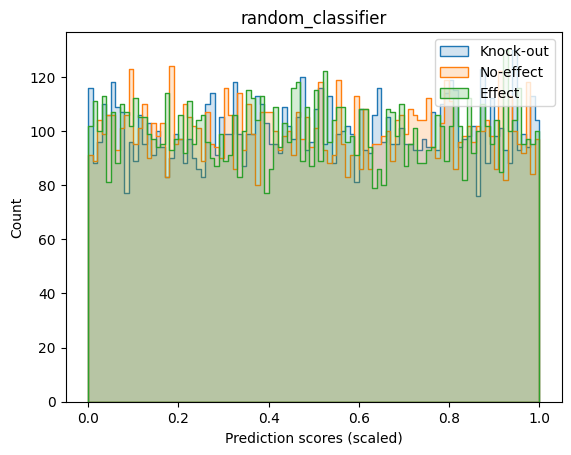

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_distribution(result_df):
    df = result_df.copy(deep=True)
    plt.cla()

    effect = result_df[result_df["functional_effect"]=="Effect"].sample(n=n_samples)
    knock_out = result_df[result_df["functional_effect"]=="Knock-out"].sample(n=n_samples)
    no_effect = result_df[result_df["functional_effect"]=="No effect"].sample(n=n_samples)

    bins = 100 # 20, 100, 500
    # plt.hist(knock_out["pred"], bins=bins, density=False, log=False, alpha=.4, label=f"Knock-out")
    # plt.hist(no_effect["pred"], bins=bins, density=False, log=False, alpha=.4, label=f"No-effect")
    # plt.hist(effect["pred"], bins=bins, density=False, log=False, alpha=.4, label=f"Effect")
    
    
    sns.histplot(knock_out["pred"], bins=bins, label=f"Knock-out", element="step", alpha=.2)
    sns.histplot(no_effect["pred"], bins=bins, label=f"No-effect", element="step", alpha=.2)
    sns.histplot(effect["pred"], bins=bins, label=f"Effect", element="step", alpha=.2)
    
    plt.title(f"{model_name}")
    plt.legend()
    plt.xlabel("Prediction scores (scaled)")
    plt.ylabel("Count")
    # plt.show()
    plt.savefig(home_dir+f"models/aa_common/pred_scores_distribution_plots_pmd_analysis/{model_name}.png", dpi=300, format="png", bbox_inches='tight', pad_inches=0.0)

pd.read_csv(home_dir+f"models/aa_common/merged_predictions/{task}.csv", sep="\t")
for i, (model_root, model_name) in enumerate(model_root_and_name_tuple_list):
    # model_name = "esm2_t33_650M_UR50D"
    print(model_name)
    model_pred_col = model_name + "_pred"
    if model_name=="random_classifier": 
        result_df[model_pred_col] = [random.uniform(0,1) for i in range(result_df.shape[0])]

    result_df["pred"]=(result_df[model_pred_col]-result_df[model_pred_col].min())/(result_df[model_pred_col].max()-result_df[model_pred_col].min()) # scaling prediction scores between [0, 1]

    non_nan_result_df, _ = get_non_nan_df(result_df, model_pred_col)
        
    if model_name in models_smaller_means_damaging:
        non_nan_result_df['pred'] = non_nan_result_df['pred'].multiply(-1)

    plot_distribution(non_nan_result_df)
    # break

	AUC-PR: 0.361
(25873,)
	Best F1-Score: 0.655 at threshold: 0.000
(25868,)
[0.48721607 0.4871963  0.48717652 ... 0.14285714 0.16666667 1.        ]
[1.00000000e+00 9.99920849e-01 9.99841697e-01 ... 7.91514960e-05
 7.91514960e-05 0.00000000e+00]


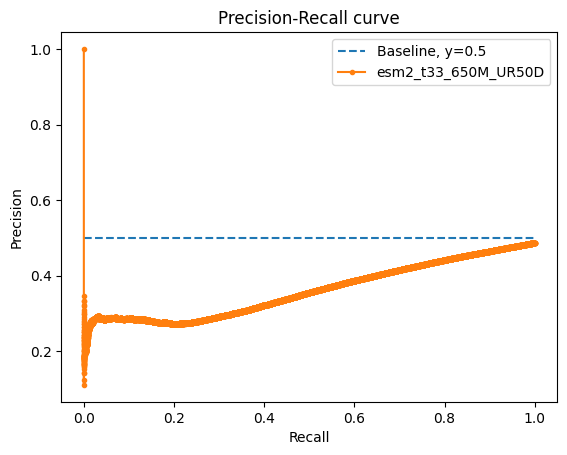

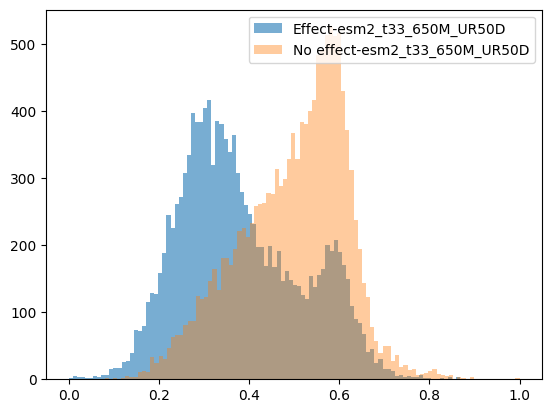

In [7]:

    

model_name = "esm2_t33_650M_UR50D"
model_pred_col = model_name + "_pred"

result_df.loc[result_df["functional_effect"]=="Effect", "class_numeric"] = 1
result_df.loc[result_df["functional_effect"]=="No effect", "class_numeric"] = 0

result_df["pred"]=(result_df[model_pred_col]-result_df[model_pred_col].min())/(result_df[model_pred_col].max()-result_df[model_pred_col].min()) # scaling prediction scores between [0, 1]

non_nan_result_df = result_df[~pd.isna(result_df[model_pred_col])]  # taking df for only non-NAN values

if model_name in models_smaller_means_damaging:
    non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)

auc_pr_score, precisions, recalls, thresholds = get_auc_pr_score(non_nan_result_df)
print(thresholds.shape)
f1_max, th_max, precisions, recalls, thresholds = get_f1max_and_th(precisions, recalls, thresholds)
print(thresholds.shape)
print(precisions, recalls, sep="\n")

# f1_max, th_max, precisions, recalls, thresholds = get_f1max_and_th_(non_nan_result_df)

import matplotlib.pyplot as plt
plt.plot([0,1], [.5, .5], linestyle='--', label='Baseline, y=0.5')
plt.plot(recalls, precisions, marker='.', label=f'{model_name}')
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.legend()
plt.title("Precision-Recall curve")
plt.show()


effect = result_df[result_df["functional_effect"]=="Effect"]
no_effect = result_df[result_df["functional_effect"]=="No effect"]

bins = 100 # 20, 100, 500
plt.hist(effect["pred"], bins=bins, density=False, log=False, alpha=.6, label=f"Effect-{model_name}")
plt.hist(no_effect["pred"], bins=bins, density=False, log=False, alpha=.4, label=f"No effect-{model_name}")

plt.legend()
plt.show()